## Univariate Performance

This procedure works as follows:

- Train a ML model per every single feature
- Determine the performance of the models
- Select features if model performance is above a certain threshold

It uses cross-validation.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection, SelectBySingleFeaturePerformance
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
train = pd.read_csv("train_C.csv")
test = pd.read_csv("test_C.csv")

In [3]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de entrenamiento
X_test = test.drop(columns=['category'])
y_test = test['category']

In [4]:
SVM = svm.SVC(kernel='rbf', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 40, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)
print('Test Score:', grid.score(X_test, y_test))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': np.float64(10.1)}
Best Cross Validation Score: 0.6389013452914798
Test Score: 0.665625


In [5]:
SVM =  grid.best_estimator_
y_pred = SVM.predict(X_test)
print('Precision en test: ', accuracy_score(y_test, y_pred))

Precision en test:  0.665625


In [22]:
# set up the selector
sel = SelectBySingleFeaturePerformance(
    variables=None, # automatically evaluate all numerical variables
    estimator=SVM, 
    scoring="accuracy",
    cv=3,
    threshold=0.184,
)

# find predictive features
sel.fit(X_train, y_train)

SelectBySingleFeaturePerformance(estimator=SVC(C=np.float64(10.1)),
                                 scoring='accuracy', threshold=0.184)

In [23]:
len(sel.features_to_drop_)

7

In [24]:
sel.feature_performance_

{'dstport.std': np.float64(0.22073279714030383),
 'frame.len.rate': np.float64(0.17068811438784628),
 'tcp.flags.ack': np.float64(0.22788203753351208),
 'tcp.flags.push': np.float64(0.09830205540661303),
 'tcp.flags.reset': np.float64(0.21358355674709562),
 'tcp.flags.syn': np.float64(0.28775692582663087),
 'tcp.flags.fin': np.float64(0.10098302055406612),
 'int.min': np.float64(0.14387846291331544),
 'int.max': np.float64(0.2439678284182306),
 'count': np.float64(0.2975871313672922),
 'ip.ttl.min': np.float64(0.18588025022341378),
 'ip.ttl.max': np.float64(0.2001787310098302),
 'tcp.seq_raw.std': np.float64(0.17158176943699732),
 'tcp.seq_raw.mean': np.float64(0.2100089365504915),
 'tcp.ack_raw.min': np.float64(0.21715817694369974),
 'tcp.window_size_value.min': np.float64(0.24307417336907955),
 'tcp.window_size_value.max': np.float64(0.22341376228775692),
 'duration': np.float64(0.18319928507596064),
 'payload.min': np.float64(0.3145665773011617),
 'payload.max': np.float64(0.1930294

Text(0, 0.5, 'accuracy')

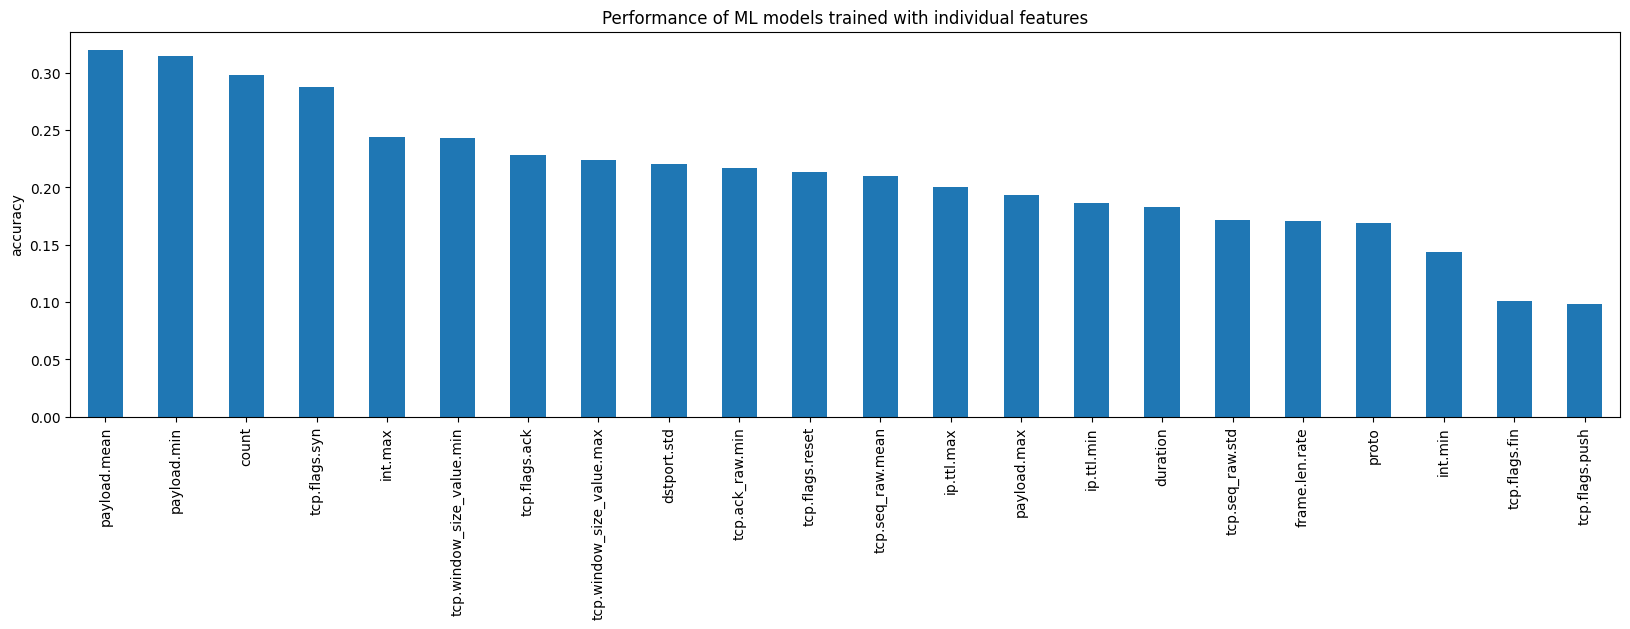

In [25]:
pd.Series(sel.feature_performance_).sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.title('Performance of ML models trained with individual features')
plt.ylabel('accuracy')

In [26]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((1119, 15), (320, 15))

In [27]:
SVM = svm.SVC(kernel='rbf', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 40, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)
print('Test Score:', grid.score(X_test, y_test))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': np.float64(21.1)}
Best Cross Validation Score: 0.6344570787956438
Test Score: 0.653125


In [28]:
SVM =  grid.best_estimator_
y_pred = SVM.predict(X_test)
print('Precision en test: ', accuracy_score(y_test, y_pred))

Precision en test:  0.653125


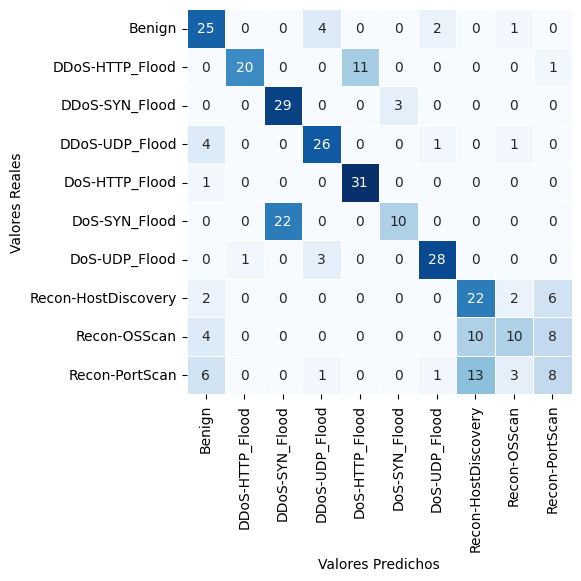

In [29]:
cm1 = confusion_matrix(y_test, y_pred)
normalized_matrix = cm1 #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [30]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
train = pd.concat([X_train, y_train], axis=1)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
test = pd.concat([X_test, y_test], axis=1)

In [31]:
train.to_csv('train_QSVM.csv', index=False)
test.to_csv('test_QSVM.csv', index=False)